Best SARIMAX(1, 0, 1)x(1, 0, 1, 12)s model - AIC:24082.30985837068


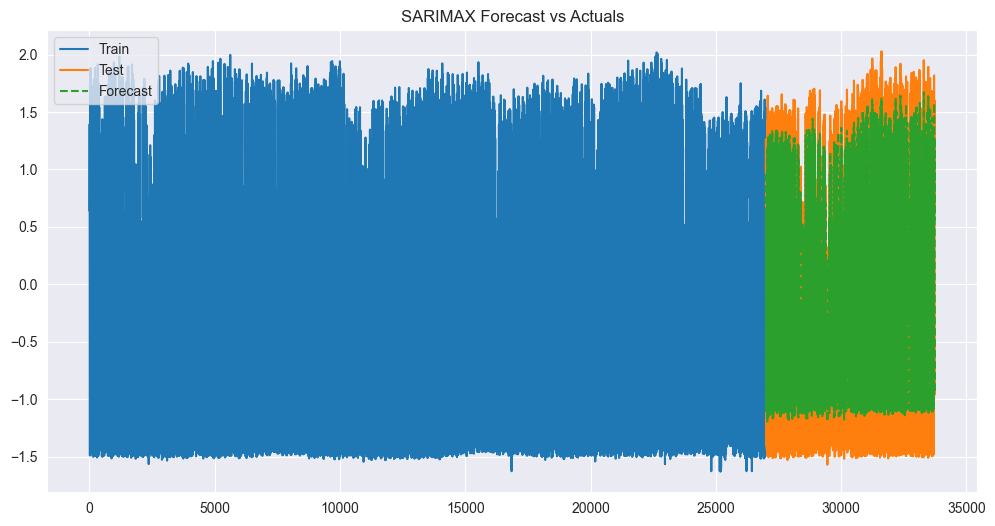

In [2]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt

# Load and preprocess the data
df_raw = pd.read_csv('Train.csv')
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])  # Corrected typo here
df_raw['hour'] = df_raw['date_time'].dt.hour

# Define your target variable
target = 'traffic_volume'

df_raw.set_index('date_time', inplace=True)
df_is_holiday = pd.get_dummies(df_raw['is_holiday'], prefix='holiday')
df_weather_type = pd.get_dummies(df_raw['weather_type'], prefix='weather_type')
df_weather_description = pd.get_dummies(df_raw['weather_description'], prefix='weather_desc')
df_processed = pd.concat([df_raw, df_is_holiday, df_weather_type, df_weather_description], axis=1)
df_processed.drop(columns=['is_holiday', 'weather_type', 'weather_description'], inplace=True)

# Feature selection and scaling
selected_features = ['traffic_volume', 'hour', 'temperature', 'clouds_all', 'humidity']
df_selected = df_processed[selected_features]
scaler = StandardScaler()
df_processed_scaled = scaler.fit_transform(df_selected)

# Prepare data for SARIMAX
n_past = 14
n_future = 1
exog_data = df_processed_scaled[:-n_future, :-1]
endog_data = df_processed_scaled[n_future:, 0]

# Split data
split_ratio = 0.8
split_point = int(len(endog_data) * split_ratio)
train_endog = endog_data[:split_point]
train_exog = exog_data[:split_point]
test_endog = endog_data[split_point:]
test_exog = exog_data[split_point:]

# Define a smaller grid for faster computation
p = d = q = range(0, 2)  # Limit to 0, 1
seasonal_p = seasonal_d = seasonal_q = range(0, 2)  # Limit to 0, 1
s = 12  # Seasonality

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d, and q triplets
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(seasonal_p, seasonal_d, seasonal_q))]

# Determine the number of samples we can draw
max_samples = min(len(pdq), len(seasonal_pdq))
n_samples = min(10, max_samples)  # Ensure n_samples does not exceed the number of combinations

# Sample indices instead of directly sampling from lists
sampled_indices = np.random.choice(range(max_samples), n_samples, replace=False)
sampled_pdq = [pdq[i] for i in sampled_indices]
sampled_seasonal_pdq = [seasonal_pdq[i] for i in sampled_indices]

best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None
best_model = None

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

for param in sampled_pdq:
    for param_seasonal in sampled_seasonal_pdq:
        try:
            model = SARIMAX(train_endog,
                            exog=train_exog,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results

        except:
            continue

print(f'Best SARIMAX{best_pdq}x{best_seasonal_pdq}s model - AIC:{best_aic}')

# Use the best model to make forecast
forecast = best_model.get_forecast(steps=len(test_endog), exog=test_exog)
forecast_values = forecast.predicted_mean

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_endog)), train_endog, label='Train')
plt.plot(range(len(train_endog), len(endog_data)), test_endog, label='Test')
plt.plot(range(len(train_endog), len(endog_data)), forecast_values, label='Forecast', linestyle='--')
plt.legend()
plt.title('SARIMAX Forecast vs Actuals')
plt.show()

In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Assume forecast_values is an array of predicted values from the SARIMAX model
forecast_values = forecast.predicted_mean

# Ensure test_endog is a numpy array for computation
test_endog = np.array(test_endog)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_endog, forecast_values))

# Compute MAE
mae = mean_absolute_error(test_endog, forecast_values)

# Compute MAPE
mape = np.mean(np.abs((test_endog - forecast_values) / test_endog)) * 100

traffic_volume_range = df_raw[target].max() - df_raw[target].min()

# Normalize RMSE and MAE
normalized_rmse = rmse / traffic_volume_range
normalized_mae = mae / traffic_volume_range

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Root Mean Squared Error (RMSE): 0.3760637064660054
Mean Absolute Error (MAE): 0.28928003527844476
Mean Absolute Percentage Error (MAPE): 92.38706838969776%


In [5]:
print(f"Normalized Root Mean Squared Error (RMSE): {normalized_rmse}")
print(f"Normalized Mean Absolute Error (MAE): {normalized_mae}")

Normalized Root Mean Squared Error (RMSE): 5.1657102536539206e-05
Normalized Mean Absolute Error (MAE): 3.973626858220395e-05


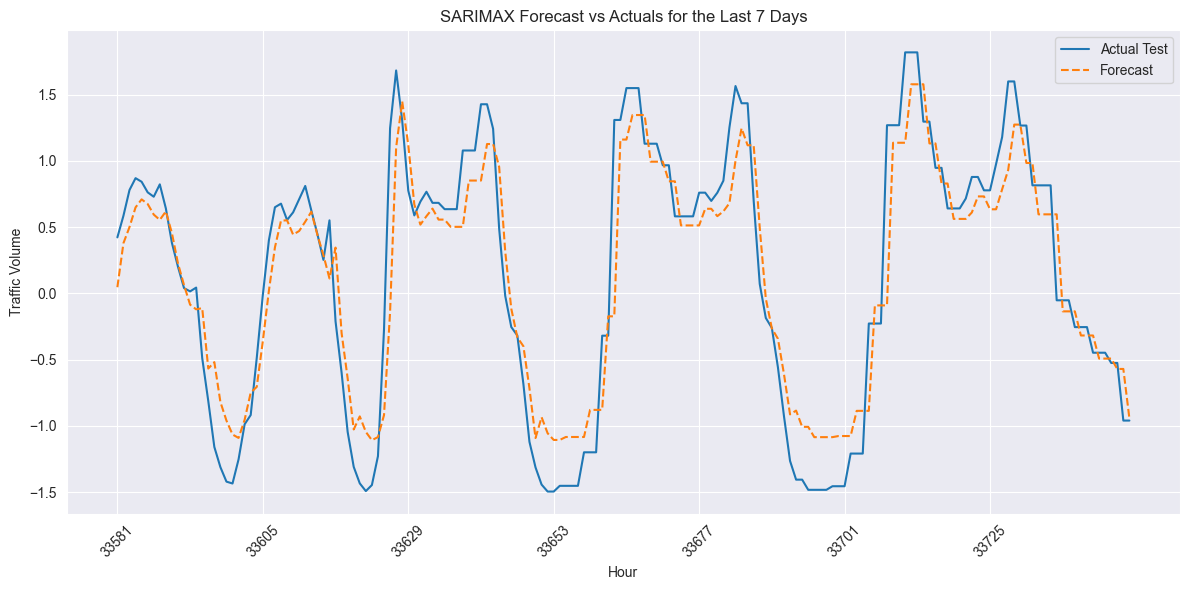

In [4]:
# Assuming the test set is hourly data and we want to visualize the last 7 days
hours_per_day = 24
days_to_visualize = 7
observations_to_visualize = hours_per_day * days_to_visualize

# Adjust the visualization range
visualization_start = len(train_endog) + len(test_endog) - observations_to_visualize
visualization_end = len(train_endog) + len(test_endog)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(range(visualization_start, visualization_end), test_endog[-observations_to_visualize:], label='Actual Test')
plt.plot(range(visualization_start, visualization_end), forecast_values[-observations_to_visualize:], label='Forecast', linestyle='--')
plt.legend()
plt.title(f'SARIMAX Forecast vs Actuals for the Last {days_to_visualize} Days')
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')
plt.xticks(range(visualization_start, visualization_end, hours_per_day), rotation=45)  # Show one tick per day for clarity
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()
